<a href="https://www.kaggle.com/code/dataranch/glass-identification-eda-model-comparison?scriptVersionId=107433790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Glass Identification Baseline Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.


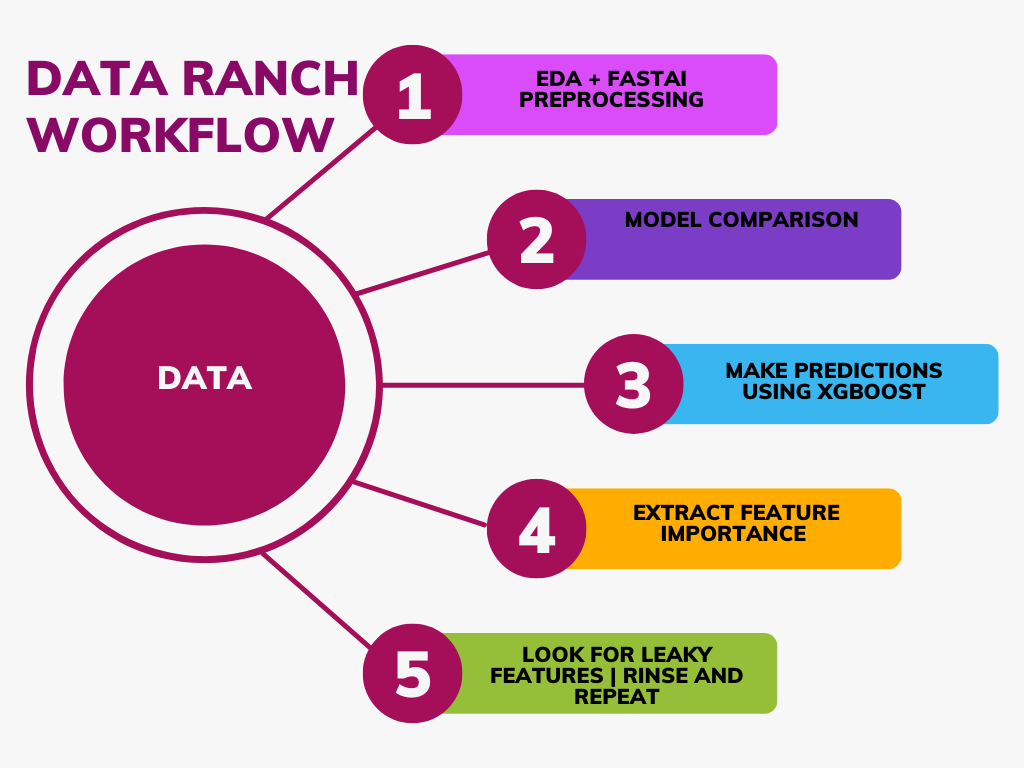

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'glass-identification-data-set'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/glass-identification-data-set
CSV!


In [12]:
df

Id   RI    Na   Mg   Al    Si    K   Ca   Ba   Fe  Type of glass
0      1 1.52 13.64 4.49 1.10 71.78 0.06 8.75 0.00 0.00              1
1      2 1.52 13.89 3.60 1.36 72.73 0.48 7.83 0.00 0.00              1
2      3 1.52 13.53 3.55 1.54 72.99 0.39 7.78 0.00 0.00              1
3      4 1.52 13.21 3.69 1.29 72.61 0.57 8.22 0.00 0.00              1
4      5 1.52 13.27 3.62 1.24 73.08 0.55 8.07 0.00 0.00              1
..   ...  ...   ...  ...  ...   ...  ...  ...  ...  ...            ...
209  210 1.52 14.14 0.00 2.88 72.61 0.08 9.18 1.06 0.00              7
210  211 1.52 14.92 0.00 1.99 73.06 0.00 8.40 1.59 0.00              7
211  212 1.52 14.36 0.00 2.02 73.42 0.00 8.44 1.64 0.00              7
212  213 1.52 14.38 0.00 1.94 73.61 0.00 8.48 1.57 0.00              7
213  214 1.52 14.23 0.00 2.08 73.36 0.00 8.62 1.67 0.00              7

[214 rows x 11 columns]

In [13]:
df.isna().sum()

Id               0
RI               0
Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type of glass    0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

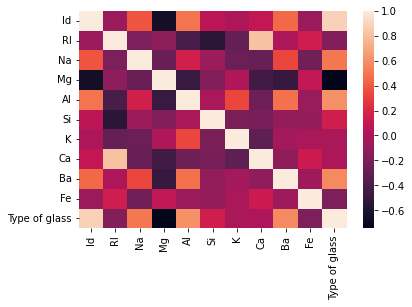

In [15]:
sns.heatmap(df.corr())

In [16]:
df.head().style.background_gradient(cmap = "inferno")

In [17]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [18]:
df.columns

Index(['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe',
       'Type of glass'],
      dtype='object')

Target Variable: Type of glass
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
11
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


 12%|█▏        | 5/42 [00:00<00:00, 48.77it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023267269134521484}
{'Model': 'BaggingRegressor', 'R-Squared': 0.996974907063197, 'Adjusted R-Squared': 0.9959990706319702, 'RMSE': 0.08591246929842249, 'Time taken': 0.028630733489990234}
{'Model': 'BayesianRidge', 'R-Squared': 0.855132991076559, 'Adjusted R-Squared': 0.8084016978754491, 'RMSE': 0.5945270068789482, 'Time taken': 0.028345823287963867}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9902416356877324, 'Adjusted R-Squared': 0.9870937762321622, 'RMSE': 0.1543033499620919, 'Time taken': 0.011969804763793945}
{'Model': 'DummyRegressor', 'R-Squared': -0.0027524171610897596, 'Adjusted R-Squared': -0.3262209388259574, 'RMSE': 1.5641690910105797, 'Time taken': 0.009945392608642578}
{'Model': 'ElasticNet', 'R-Squared': 0.6640672977640706, 'Adjusted R-Squared': 0.5557019099460289, 'RMSE': 0.90534264, 'Time taken': 0.014367103576660156}
{'Model': 'ElasticNetCV', 'R-Squared': 0

 24%|██▍       | 10/42 [00:00<00:01, 28.99it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9935058085501859, 'Adjusted R-Squared': 0.9914109080825039, 'RMSE': 0.12587786975969242, 'Time taken': 0.11635923385620117}
{'Model': 'GammaRegressor', 'R-Squared': 0.7567159969982102, 'Adjusted R-Squared': 0.6782372863524716, 'RMSE': 0.7704485062274642, 'Time taken': 0.012695789337158203}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.09493559884569058, 'Adjusted R-Squared': -0.4481406307313971, 'RMSE': 1.634485713396409, 'Time taken': 0.037869930267333984}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9995499580652389, 'Adjusted R-Squared': 0.9994047832475741, 'RMSE': 0.03313701104032849, 'Time taken': 0.13083600997924805}


 33%|███▎      | 14/42 [00:00<00:01, 19.63it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9914793669716331, 'Adjusted R-Squared': 0.9887307756721598, 'RMSE': 0.14418589300858176, 'Time taken': 0.10870194435119629}
{'Model': 'HuberRegressor', 'R-Squared': 0.8464589594327344, 'Adjusted R-Squared': 0.7969295915078101, 'RMSE': 0.612067163274696, 'Time taken': 0.022375822067260742}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.743550185873606, 'Adjusted R-Squared': 0.6608244393812208, 'RMSE': 0.7910210399946931, 'Time taken': 0.011316061019897461}
{'Model': 'KernelRidge', 'R-Squared': -1.838529784550897, 'Adjusted R-Squared': -2.754184553760864, 'RMSE': 2.6316829, 'Time taken': 0.02974724769592285}
{'Model': 'Lars', 'R-Squared': 0.8605111448817679, 'Adjusted R-Squared': 0.8155147400049189, 'RMSE': 0.5833868, 'Time taken': 0.02699446678161621}


 43%|████▎     | 18/42 [00:00<00:01, 22.78it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8516517870982616, 'Adjusted R-Squared': 0.8037975248718944, 'RMSE': 0.60162795, 'Time taken': 0.05628657341003418}
{'Model': 'Lasso', 'R-Squared': 0.4891083346612849, 'Adjusted R-Squared': 0.3243045716487962, 'RMSE': 1.1164807, 'Time taken': 0.022284746170043945}


 52%|█████▏    | 22/42 [00:00<00:00, 25.29it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8512635580856522, 'Adjusted R-Squared': 0.8032840606939271, 'RMSE': 0.60241467, 'Time taken': 0.06195330619812012}
{'Model': 'LassoLars', 'R-Squared': -0.0027524244497256767, 'Adjusted R-Squared': -0.3262209484657661, 'RMSE': 1.564169, 'Time taken': 0.010199546813964844}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8504424611571595, 'Adjusted R-Squared': 0.8021980937885013, 'RMSE': 0.6040752, 'Time taken': 0.02762317657470703}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8503688634078761, 'Adjusted R-Squared': 0.8021007548297716, 'RMSE': 0.6042238, 'Time taken': 0.02057647705078125}
{'Model': 'LinearRegression', 'R-Squared': 0.8605118204542701, 'Adjusted R-Squared': 0.8155156335040347, 'RMSE': 0.58338535, 'Time taken': 0.0097503662109375}
{'Model': 'LinearSVR', 'R-Squared': 0.8413763350988674, 'Adjusted R-Squared': 0.7902074109372118, 'RMSE': 0.6221152262441089, 'Time taken': 0.013091802597045898}


 71%|███████▏  | 30/42 [00:01<00:00, 18.88it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.826873184616131, 'Adjusted R-Squared': 0.7710258248148829, 'RMSE': 0.6499336, 'Time taken': 0.4242420196533203}
{'Model': 'NuSVR', 'R-Squared': 0.8238982996144086, 'Adjusted R-Squared': 0.7670912994900243, 'RMSE': 0.6554938413116459, 'Time taken': 0.028022050857543945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7783133093796596, 'Adjusted R-Squared': 0.7068014736956788, 'RMSE': 0.7354559249046085, 'Time taken': 0.022508859634399414}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.807320207846502, 'Adjusted R-Squared': 0.7451654361840834, 'RMSE': 0.6856538603620608, 'Time taken': 0.03256940841674805}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.587887858400451, 'Adjusted R-Squared': 0.45494845788446747, 'RMSE': 1.0027543296923795, 'Time taken': 0.02254176139831543}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8301264952427142, 'Adjusted R-Squared': 0.7753285904822994, 'RMSE': 0.6437980611807829, 'Time taken': 0.013590

 79%|███████▊  | 33/42 [00:02<00:00, 10.43it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.09293680299557461, 'Adjusted R-Squared': -0.44549706202640516, 'RMSE': 1.6329931618715865, 'Time taken': 0.5829324722290039}
{'Model': 'RANSACRegressor', 'R-Squared': 0.7624662011935589, 'Adjusted R-Squared': 0.685842395126965, 'RMSE': 0.761289, 'Time taken': 0.06423592567443848}


 83%|████████▎ | 35/42 [00:02<00:00, 10.31it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.997848280669145, 'Adjusted R-Squared': 0.9971541776591918, 'RMSE': 0.07245688373094722, 'Time taken': 0.18976831436157227}
{'Model': 'Ridge', 'R-Squared': 0.8557371818391213, 'Adjusted R-Squared': 0.8092007888839992, 'RMSE': 0.5932859, 'Time taken': 0.010626792907714844}
{'Model': 'RidgeCV', 'R-Squared': 0.8557374324871345, 'Adjusted R-Squared': 0.8092011203862102, 'RMSE': 0.5932854116622577, 'Time taken': 0.010675430297851562}
{'Model': 'SGDRegressor', 'R-Squared': 0.8433116565361537, 'Adjusted R-Squared': 0.7927670296123324, 'RMSE': 0.618308455349868, 'Time taken': 0.01024174690246582}
{'Model': 'SVR', 'R-Squared': 0.8278746210974903, 'Adjusted R-Squared': 0.7723503053224872, 'RMSE': 0.6480511648341186, 'Time taken': 0.011867046356201172}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8605118204542701, 'Adjusted R-Squared': 0.8155156335040347, 'RMSE': 0.58338535, 'Time taken': 0.010356664657592773}
{'Model': 'TweedieRegressor'

100%|██████████| 42/42 [00:02<00:00, 14.61it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9902447697927719, 'Adjusted R-Squared': 0.9870979213388273, 'RMSE': 0.15427858, 'Time taken': 0.38722920417785645}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9942532961263377, 'Adjusted R-Squared': 0.9923995206832209, 'RMSE': 0.11841214552888654, 'Time taken': 0.10875654220581055}
Project: glass-identification-data-set
glass-identification-data-set
Target: Type of glass
Type of glass
Target Standard Deviation: 1.7361053121710734
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
GradientBoostingRegressor                    1.00       1.00  0.03        0.13
RandomForestRegressor                        1.00       1.00  0.07        0.19
BaggingRegressor                             1.00       1.00  0.09        0.03
LGBMRegressor                                0.99    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 21.843669891357422.
Better model found at epoch 1 with _rmse value: 20.21194839477539.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       4.00
1       1       1.00
2       4       4.00
3       2       2.00
4       2       2.00
XGBoost RMSE:  0.15427858


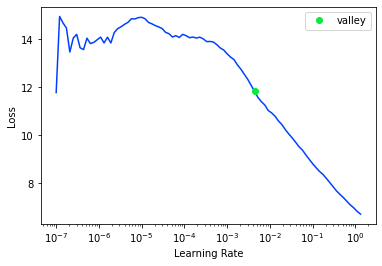

<Figure size 720x720 with 0 Axes>

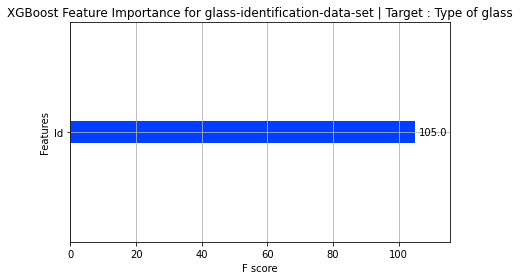

Target Variable: Fe
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.20it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.07863925501236058, 'Adjusted R-Squared': -0.21857388853203918, 'RMSE': 0.11665954194219656, 'Time taken': 0.09744000434875488}
{'Model': 'BaggingRegressor', 'R-Squared': 0.28929426439116845, 'Adjusted R-Squared': 0.060034349678642185, 'RMSE': 0.10245904994287128, 'Time taken': 0.033945322036743164}
{'Model': 'BayesianRidge', 'R-Squared': 0.023109170327728412, 'Adjusted R-Squared': -0.29201690376010103, 'RMSE': 0.12012362533914894, 'Time taken': 0.01315450668334961}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.03597237508879769, 'Adjusted R-Squared': -0.37015701221421615, 'RMSE': 0.12370279197316153, 'Time taken': 0.011263132095336914}
{'Model': 'DummyRegressor', 'R-Squared': -0.022514845421703455, 'Adjusted R-Squared': -0.35235834394483345, 'RMSE': 0.1228967, 'Time taken': 0.009820699691772461}
{'Model': 'ElasticNet', 'R-Squared': -0.022514845421703455, 'Adjusted R-Squared': -0.35235834394483345, 'RMSE': 0.1228967, 'Time taken': 0.011

 21%|██▏       | 9/42 [00:00<00:01, 17.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.12558820983245578, 'Adjusted R-Squared': -0.15648010957642944, 'RMSE': 0.11364842, 'Time taken': 0.19241905212402344}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.06885525920703905, 'Adjusted R-Squared': -0.41364727830608383, 'RMSE': 0.12565068588766484, 'Time taken': 0.012326240539550781}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.166567957700977, 'Adjusted R-Squared': -0.1022810882019336, 'RMSE': 0.11095337343101312, 'Time taken': 0.12779808044433594}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.4496443157794028, 'Adjusted R-Squared': -2.23985215957921, 'RMSE': 0.19022032941294187, 'Time taken': 0.02008223533630371}


 33%|███▎      | 14/42 [00:00<00:01, 16.06it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.25706400401817786, 'Adjusted R-Squared': 0.01740723112081588, 'RMSE': 0.10475653254706299, 'Time taken': 0.13176751136779785}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.12870807133312256, 'Adjusted R-Squared': -0.15235384114006356, 'RMSE': 0.1134454964093468, 'Time taken': 0.11039590835571289}
{'Model': 'HuberRegressor', 'R-Squared': -0.3477116202724604, 'Adjusted R-Squared': -0.7824573042313185, 'RMSE': 0.14109249093913206, 'Time taken': 0.04522228240966797}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.010291460136922614, 'Adjusted R-Squared': -0.33619193114883306, 'RMSE': 0.12215993, 'Time taken': 0.013025999069213867}
{'Model': 'KernelRidge', 'R-Squared': -0.25553267041080696, 'Adjusted R-Squared': -0.6605432092530026, 'RMSE': 0.1361819, 'Time taken': 0.016009807586669922}


 43%|████▎     | 18/42 [00:00<00:01, 21.16it/s]

{'Model': 'Lars', 'R-Squared': 0.17024746133030533, 'Adjusted R-Squared': -0.09741464791798315, 'RMSE': 0.11070818, 'Time taken': 0.03017425537109375}
{'Model': 'LarsCV', 'R-Squared': 0.02786411707786496, 'Adjusted R-Squared': -0.28572810321959796, 'RMSE': 0.11983092, 'Time taken': 0.0517115592956543}
{'Model': 'Lasso', 'R-Squared': -0.022514845421703455, 'Adjusted R-Squared': -0.35235834394483345, 'RMSE': 0.1228967, 'Time taken': 0.023654460906982422}


 62%|██████▏   | 26/42 [00:01<00:00, 22.20it/s]

{'Model': 'LassoCV', 'R-Squared': 0.12727634143333977, 'Adjusted R-Squared': -0.15424741939461506, 'RMSE': 0.11353867, 'Time taken': 0.1976909637451172}
{'Model': 'LassoLars', 'R-Squared': -0.022514845421703455, 'Adjusted R-Squared': -0.35235834394483345, 'RMSE': 0.1228967, 'Time taken': 0.011683464050292969}
{'Model': 'LassoLarsCV', 'R-Squared': 0.12447422033692812, 'Adjusted R-Squared': -0.15795345052212717, 'RMSE': 0.11372079, 'Time taken': 0.030461788177490234}
{'Model': 'LassoLarsIC', 'R-Squared': 0.17024728819327983, 'Adjusted R-Squared': -0.0974148769056622, 'RMSE': 0.1107082, 'Time taken': 0.013959646224975586}
{'Model': 'LinearRegression', 'R-Squared': 0.17024578203310026, 'Adjusted R-Squared': -0.09741686892396406, 'RMSE': 0.1107083, 'Time taken': 0.010628461837768555}
{'Model': 'LinearSVR', 'R-Squared': -0.33795667287083986, 'Adjusted R-Squared': -0.7695555996033687, 'RMSE': 0.14058093883093217, 'Time taken': 0.01930713653564453}
{'Model': 'MLPRegressor', 'R-Squared': -5.104

 71%|███████▏  | 30/42 [00:01<00:00, 25.23it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0681687655439499, 'Adjusted R-Squared': -0.2324219552483242, 'RMSE': 0.11732053808904067, 'Time taken': 0.03579449653625488}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.014893920550899331, 'Adjusted R-Squared': -0.30288223411010073, 'RMSE': 0.12062766299275758, 'Time taken': 0.021050691604614258}
{'Model': 'PoissonRegressor', 'R-Squared': -0.010964325799088792, 'Adjusted R-Squared': -0.3370818502504076, 'RMSE': 0.12220059760233686, 'Time taken': 0.011823415756225586}


 79%|███████▊  | 33/42 [00:02<00:00, 10.34it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.34771510401188443, 'Adjusted R-Squared': -0.7824619117576534, 'RMSE': 0.14109267329608, 'Time taken': 0.6223599910736084}
{'Model': 'RANSACRegressor', 'R-Squared': -0.34771510038839226, 'Adjusted R-Squared': -0.7824619069652929, 'RMSE': 0.14109267, 'Time taken': 0.1354374885559082}


 86%|████████▌ | 36/42 [00:02<00:00, 11.14it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.22111435976758909, 'Adjusted R-Squared': -0.03013907256544668, 'RMSE': 0.10726110406083843, 'Time taken': 0.18838858604431152}
{'Model': 'Ridge', 'R-Squared': 0.09736893516020118, 'Adjusted R-Squared': -0.19380237607844353, 'RMSE': 0.115467705, 'Time taken': 0.01177525520324707}
{'Model': 'RidgeCV', 'R-Squared': 0.1612100803185984, 'Adjusted R-Squared': -0.10936731312701498, 'RMSE': 0.11130944457735344, 'Time taken': 0.011803627014160156}
{'Model': 'SGDRegressor', 'R-Squared': 0.06783953575766855, 'Adjusted R-Squared': -0.23285738819147062, 'RMSE': 0.11734126180119098, 'Time taken': 0.012975215911865234}
{'Model': 'SVR', 'R-Squared': -0.02768265337254494, 'Adjusted R-Squared': -0.3591931867185272, 'RMSE': 0.12320687075040444, 'Time taken': 0.012014627456665039}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.17024578203310026, 'Adjusted R-Squared': -0.09741686892396406, 'RMSE': 0.1107083, 'Time taken': 0.010786056518554688}
{'Mod

100%|██████████| 42/42 [00:02<00:00, 14.11it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.19854198671284617, 'Adjusted R-Squared': -0.05999285628300988, 'RMSE': 0.10880424, 'Time taken': 0.4172515869140625}
{'Model': 'LGBMRegressor', 'R-Squared': 0.10942229799744385, 'Adjusted R-Squared': -0.1778608316807999, 'RMSE': 0.11469416473351048, 'Time taken': 0.07691097259521484}
Project: glass-identification-data-set
glass-identification-data-set
Target: Fe
Fe
Target Standard Deviation: 0.08991843461990356
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BaggingRegressor                             0.06       0.29  0.10        0.03
GradientBoostingRegressor                    0.02       0.26  0.10        0.13
RandomForestRegressor                       -0.03       0.22  0.11        0.19
XGBRegressor                                -0.06       0.20  0.11        0.42
Lars                                        -0.10       0.17  0.11    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 8.091351509094238.
Better model found at epoch 1 with _rmse value: 7.406659126281738.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

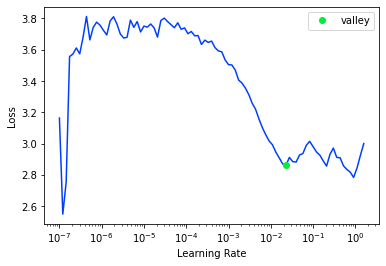

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.02
1    0.00      -0.02
2    0.00      -0.01
3    0.00       0.09
4    0.00       0.08
XGBoost RMSE:  0.10882048


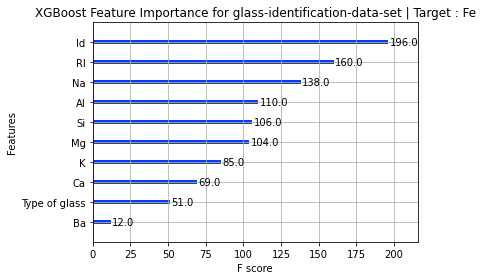

Target Variable: Ba
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


 10%|▉         | 4/42 [00:00<00:01, 35.55it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -403.3238943579636, 'Adjusted R-Squared': -533.7509570540808, 'RMSE': 0.4211976357740158, 'Time taken': 0.05456137657165527}
{'Model': 'BaggingRegressor', 'R-Squared': -304.8332742887824, 'Adjusted R-Squared': -403.4891692206476, 'RMSE': 0.3663224947175467, 'Time taken': 0.03234982490539551}
{'Model': 'BayesianRidge', 'R-Squared': -21.459942073118793, 'Adjusted R-Squared': -28.70508467735066, 'RMSE': 0.09927171777650062, 'Time taken': 0.012232065200805664}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -582.4852205643822, 'Adjusted R-Squared': -770.7062594561183, 'RMSE': 0.5059832624981563, 'Time taken': 0.01301264762878418}
{'Model': 'DummyRegressor', 'R-Squared': -101.15995648645418, 'Adjusted R-Squared': -134.1147811595039, 'RMSE': 0.21171984, 'Time taken': 0.013172626495361328}
{'Model': 'ElasticNet', 'R-Squared': -101.15995648645418, 'Adjusted R-Squared': -134.1147811595039, 'RMSE': 0.21171984, 'Time taken': 0.011559486389160156}


 19%|█▉        | 8/42 [00:00<00:00, 34.31it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -18.608372995422517, 'Adjusted R-Squared': -24.933654606849135, 'RMSE': 0.092755996, 'Time taken': 0.07990193367004395}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1020.9944952818036, 'Adjusted R-Squared': -1350.670138921095, 'RMSE': 0.669646339616455, 'Time taken': 0.01321268081665039}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -562.3147945535993, 'Adjusted R-Squared': -744.0292444095991, 'RMSE': 0.49716071013293306, 'Time taken': 0.12238883972167969}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.6015914926618762, 'Adjusted R-Squared': -2.4408145548108684, 'RMSE': 0.033786310802286335, 'Time taken': 0.02139592170715332}


 29%|██▊       | 12/42 [00:00<00:01, 20.56it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -394.4051019764702, 'Adjusted R-Squared': -521.9551348721056, 'RMSE': 0.4165262298402211, 'Time taken': 0.13445806503295898}


 36%|███▌      | 15/42 [00:00<00:01, 20.09it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -339.7422133540262, 'Adjusted R-Squared': -449.65905637145397, 'RMSE': 0.3866644021287177, 'Time taken': 0.11699414253234863}
{'Model': 'HuberRegressor', 'R-Squared': -43.17180650531334, 'Adjusted R-Squared': -57.420776345736996, 'RMSE': 0.13921749065806605, 'Time taken': 0.02626633644104004}
{'Model': 'KNeighborsRegressor', 'R-Squared': -331.7233131377169, 'Adjusted R-Squared': -439.0534141498836, 'RMSE': 0.3820875, 'Time taken': 0.01136469841003418}
{'Model': 'KernelRidge', 'R-Squared': -127.85268324636638, 'Adjusted R-Squared': -169.41806493874262, 'RMSE': 0.23777597, 'Time taken': 0.017641782760620117}
{'Model': 'Lars', 'R-Squared': -1712.2610172929342, 'Adjusted R-Squared': -2264.925861580977, 'RMSE': 0.8670277, 'Time taken': 0.026847124099731445}


 43%|████▎     | 18/42 [00:00<00:01, 22.21it/s]

{'Model': 'LarsCV', 'R-Squared': -365.3795232699568, 'Adjusted R-Squared': -483.56646626026543, 'RMSE': 0.40094686, 'Time taken': 0.058249711990356445}
{'Model': 'Lasso', 'R-Squared': -101.15995648645418, 'Adjusted R-Squared': -134.1147811595039, 'RMSE': 0.21171984, 'Time taken': 0.02357649803161621}


 50%|█████     | 21/42 [00:00<00:00, 23.62it/s]

{'Model': 'LassoCV', 'R-Squared': -19.907913886160017, 'Adjusted R-Squared': -26.652402236534215, 'RMSE': 0.09578039, 'Time taken': 0.0724935531616211}
{'Model': 'LassoLars', 'R-Squared': -101.15995648645418, 'Adjusted R-Squared': -134.1147811595039, 'RMSE': 0.21171984, 'Time taken': 0.010807991027832031}
{'Model': 'LassoLarsCV', 'R-Squared': -22.218719501914116, 'Adjusted R-Squared': -29.708629018660602, 'RMSE': 0.10093467, 'Time taken': 0.029181957244873047}
{'Model': 'LassoLarsIC', 'R-Squared': -22.218719501914116, 'Adjusted R-Squared': -29.708629018660602, 'RMSE': 0.10093467, 'Time taken': 0.014745235443115234}
{'Model': 'LinearRegression', 'R-Squared': -22.21897510513987, 'Adjusted R-Squared': -29.708967074539824, 'RMSE': 0.10093522, 'Time taken': 0.010680437088012695}
{'Model': 'LinearSVR', 'R-Squared': -43.424587102894854, 'Adjusted R-Squared': -57.75509907157061, 'RMSE': 0.1396152701413746, 'Time taken': 0.016373634338378906}


 69%|██████▉   | 29/42 [00:01<00:00, 20.43it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1920.4319573440162, 'Adjusted R-Squared': -2540.2487177775697, 'RMSE': 0.91819245, 'Time taken': 0.2797982692718506}
{'Model': 'NuSVR', 'R-Squared': -41.08556618344827, 'Adjusted R-Squared': -54.6615552748832, 'RMSE': 0.13589009681616956, 'Time taken': 0.04216790199279785}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -193.48716987956263, 'Adjusted R-Squared': -256.2249666149054, 'RMSE': 0.29212363715458606, 'Time taken': 0.02253127098083496}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -1326.7626145506547, 'Adjusted R-Squared': -1755.0731353734463, 'RMSE': 0.7632757050153021, 'Time taken': 0.034909963607788086}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -136.463875095672, 'Adjusted R-Squared': -180.80706061040487, 'RMSE': 0.24559273309143978, 'Time taken': 0.015943050384521484}
{'Model': 'PoissonRegressor', 'R-Squared': -189.11158839869287, 'Adjusted R-Squared': -250.4379072369809, 'RMSE': 0.28881883787836893, 'Time take

 76%|███████▌  | 32/42 [00:01<00:00, 10.58it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07441851469116334, 'Adjusted R-Squared': -0.42100513233347403, 'RMSE': 0.021712406575768173, 'Time taken': 0.6091041564941406}
{'Model': 'RANSACRegressor', 'R-Squared': -0.07441847059071183, 'Adjusted R-Squared': -0.4210050740070703, 'RMSE': 0.021712406, 'Time taken': 0.11965489387512207}


 81%|████████  | 34/42 [00:02<00:00,  9.43it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -263.9563391454393, 'Adjusted R-Squared': -349.42612596654874, 'RMSE': 0.3409638829853078, 'Time taken': 0.17632174491882324}
{'Model': 'Ridge', 'R-Squared': -37.67046936297536, 'Adjusted R-Squared': -50.14481431877386, 'RMSE': 0.13025996, 'Time taken': 0.011157989501953125}
{'Model': 'RidgeCV', 'R-Squared': -19.350173887125393, 'Adjusted R-Squared': -25.914746108778743, 'RMSE': 0.09449422842594435, 'Time taken': 0.01068568229675293}
{'Model': 'SGDRegressor', 'R-Squared': -876.2366860405074, 'Adjusted R-Squared': -1159.2162621826064, 'RMSE': 0.6204111777531064, 'Time taken': 0.010627031326293945}
{'Model': 'SVR', 'R-Squared': -87.83847261277532, 'Adjusted R-Squared': -116.496044423348, 'RMSE': 0.19743391733866864, 'Time taken': 0.01226496696472168}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -22.21897510513987, 'Adjusted R-Squared': -29.708967074539824, 'RMSE': 0.10093522, 'Time taken': 0.011070966720581055}
{'Model': 'TweedieReg

100%|██████████| 42/42 [00:02<00:00, 15.09it/s]

{'Model': 'XGBRegressor', 'R-Squared': -538.3528416458992, 'Adjusted R-Squared': -712.3376292736085, 'RMSE': 0.48647186, 'Time taken': 0.38455653190612793}
{'Model': 'LGBMRegressor', 'R-Squared': -305.8124027257801, 'Adjusted R-Squared': -404.78414554054785, 'RMSE': 0.3669084187872601, 'Time taken': 0.043070077896118164}
Project: glass-identification-data-set
glass-identification-data-set
Target: Ba
Ba
Target Standard Deviation: 0.5452893972396851
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RANSACRegressor                             -0.42      -0.07  0.02        0.12
QuantileRegressor                           -0.42      -0.07  0.02        0.61
GaussianProcessRegressor                    -2.44      -1.60  0.03        0.02
ElasticNetCV                               -24.93     -18.61  0.09        0.08
RidgeCV                                    -25.91     -19.35  0.09        

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 18.90144920349121.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

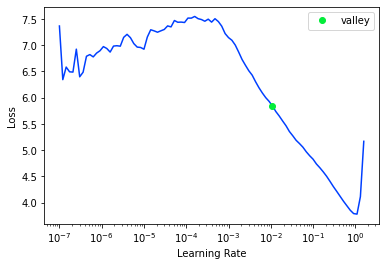

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00      -0.00
1    0.00      -0.00
2    0.00       0.00
3    0.00       0.37
4    0.00       0.01
XGBoost RMSE:  0.48647186


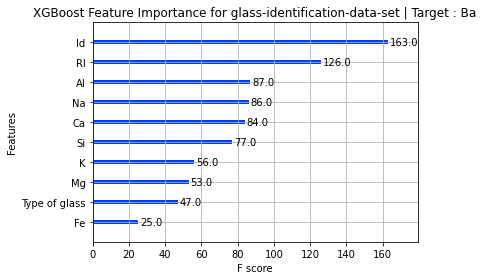

Target Variable: Ca
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  2%|▏         | 1/42 [00:00<00:04,  9.94it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7349379116407686, 'Adjusted R-Squared': 0.6494340121700488, 'RMSE': 0.5288642645095988, 'Time taken': 0.10018587112426758}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7793843599680663, 'Adjusted R-Squared': 0.7082180244738943, 'RMSE': 0.4824902744460321, 'Time taken': 0.03510594367980957}
{'Model': 'BayesianRidge', 'R-Squared': 0.9906668576312673, 'Adjusted R-Squared': 0.9876561665445793, 'RMSE': 0.0992394526497004, 'Time taken': 0.012370824813842773}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.12759346382571457, 'Adjusted R-Squared': -0.15382799945631298, 'RMSE': 0.9594666203199066, 'Time taken': 0.012522220611572266}
{'Model': 'DummyRegressor', 'R-Squared': -0.0805629771593559, 'Adjusted R-Squared': -0.4291316794688256, 'RMSE': 1.0678136, 'Time taken': 0.01075601577758789}


 17%|█▋        | 7/42 [00:00<00:01, 30.29it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.39210956273744935, 'Adjusted R-Squared': 0.19601587329791692, 'RMSE': 0.8009088, 'Time taken': 0.013510704040527344}
{'Model': 'ElasticNetCV', 'R-Squared': 0.990083225294652, 'Adjusted R-Squared': 0.9868842657122816, 'RMSE': 0.10229529, 'Time taken': 0.06476783752441406}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.013089543888110122, 'Adjusted R-Squared': -0.30526866776088646, 'RMSE': 1.0204912612401458, 'Time taken': 0.0142059326171875}


 24%|██▍       | 10/42 [00:00<00:01, 23.36it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.849013690967816, 'Adjusted R-Squared': 0.8003084299896921, 'RMSE': 0.39915281757610127, 'Time taken': 0.14505767822265625}
{'Model': 'GammaRegressor', 'R-Squared': 0.7341926989462166, 'Adjusted R-Squared': 0.6484484082837059, 'RMSE': 0.5296071842981447, 'Time taken': 0.013779878616333008}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -11.007830972041587, 'Adjusted R-Squared': -14.881324833990485, 'RMSE': 3.5596122929954372, 'Time taken': 0.03091883659362793}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8923010320606435, 'Adjusted R-Squared': 0.8575594294995608, 'RMSE': 0.3371135319496982, 'Time taken': 0.12927007675170898}


 43%|████▎     | 18/42 [00:00<00:01, 22.01it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.654846335673289, 'Adjusted R-Squared': 0.5435064439549951, 'RMSE': 0.6034991450253026, 'Time taken': 0.12013673782348633}
{'Model': 'HuberRegressor', 'R-Squared': 0.9907040422024973, 'Adjusted R-Squared': 0.9877053461387868, 'RMSE': 0.0990415632766666, 'Time taken': 0.026488542556762695}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6283754460191024, 'Adjusted R-Squared': 0.5084965576381677, 'RMSE': 0.6262137, 'Time taken': 0.01180887222290039}
{'Model': 'KernelRidge', 'R-Squared': -76.03320765734995, 'Adjusted R-Squared': -100.88262948230154, 'RMSE': 9.015906, 'Time taken': 0.016142606735229492}
{'Model': 'Lars', 'R-Squared': 0.9906757731440942, 'Adjusted R-Squared': 0.9876679580292859, 'RMSE': 0.099192046, 'Time taken': 0.025119543075561523}
{'Model': 'LarsCV', 'R-Squared': 0.9906757731440942, 'Adjusted R-Squared': 0.9876679580292859, 'RMSE': 0.099192046, 'Time taken': 0.05396771430969238}
{'Model': 'Lasso', 'R-Squared': 0.1

 50%|█████     | 21/42 [00:00<00:00, 23.10it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9903427065719503, 'Adjusted R-Squared': 0.9872274506274182, 'RMSE': 0.100948095, 'Time taken': 0.07555818557739258}
{'Model': 'LassoLars', 'R-Squared': -0.0805629771593559, 'Adjusted R-Squared': -0.4291316794688256, 'RMSE': 1.0678136, 'Time taken': 0.012176990509033203}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9906757731440942, 'Adjusted R-Squared': 0.9876679580292859, 'RMSE': 0.099192046, 'Time taken': 0.027410507202148438}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9903924067771803, 'Adjusted R-Squared': 0.9872931831569159, 'RMSE': 0.100688, 'Time taken': 0.015236616134643555}
{'Model': 'LinearRegression', 'R-Squared': 0.9906757257433475, 'Adjusted R-Squared': 0.9876678953379757, 'RMSE': 0.09919229, 'Time taken': 0.011917591094970703}
{'Model': 'LinearSVR', 'R-Squared': 0.9915837615718291, 'Adjusted R-Squared': 0.9888688459498386, 'RMSE': 0.09423873116601401, 'Time taken': 0.01872563362121582}


 71%|███████▏  | 30/42 [00:01<00:00, 19.03it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.7281222600029746, 'Adjusted R-Squared': -2.6081616987136114, 'RMSE': 1.6966894, 'Time taken': 0.39525365829467773}
{'Model': 'NuSVR', 'R-Squared': 0.7797196120674195, 'Adjusted R-Squared': 0.7086614224117483, 'RMSE': 0.48212353395557045, 'Time taken': 0.029695749282836914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.37357730027796165, 'Adjusted R-Squared': 0.17150546165794933, 'RMSE': 0.8130254835905733, 'Time taken': 0.02251577377319336}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9088971089544405, 'Adjusted R-Squared': 0.8795090795849052, 'RMSE': 0.3100533973915042, 'Time taken': 0.03558468818664551}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9864026346468582, 'Adjusted R-Squared': 0.9820163877587479, 'RMSE': 0.11978372055875447, 'Time taken': 0.022620677947998047}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9422613923465621, 'Adjusted R-Squared': 0.9236360350390016, 'RMSE': 0.24683319705216158, 'Time taken'

 79%|███████▊  | 33/42 [00:02<00:01,  6.54it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.005307266128720123, 'Adjusted R-Squared': -0.3295999326218555, 'RMSE': 1.0299587363128868, 'Time taken': 1.2464241981506348}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9899765293088009, 'Adjusted R-Squared': 0.9867431516664785, 'RMSE': 0.10284413, 'Time taken': 0.08759284019470215}


 83%|████████▎ | 35/42 [00:03<00:01,  6.84it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7839074754697242, 'Adjusted R-Squared': 0.7142002094922159, 'RMSE': 0.47751859335332036, 'Time taken': 0.2225341796875}
{'Model': 'Ridge', 'R-Squared': 0.9889642469957061, 'Adjusted R-Squared': 0.9854043266717403, 'RMSE': 0.107912414, 'Time taken': 0.01132512092590332}
{'Model': 'RidgeCV', 'R-Squared': 0.9906286128808612, 'Adjusted R-Squared': 0.9876055847779133, 'RMSE': 0.09944257330129007, 'Time taken': 0.011735916137695312}
{'Model': 'SGDRegressor', 'R-Squared': 0.9375558453298477, 'Adjusted R-Squared': 0.9174125696297986, 'RMSE': 0.25669435038402155, 'Time taken': 0.010927438735961914}
{'Model': 'SVR', 'R-Squared': 0.7758118461827086, 'Adjusted R-Squared': 0.7034930868868081, 'RMSE': 0.48638116120318486, 'Time taken': 0.012262582778930664}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9906757257433475, 'Adjusted R-Squared': 0.9876678953379757, 'RMSE': 0.09919229, 'Time taken': 0.011751890182495117}
{'Model': 'TweedieRegress

100%|██████████| 42/42 [00:03<00:00, 10.62it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7829886875633567, 'Adjusted R-Squared': 0.712985038390246, 'RMSE': 0.4785327, 'Time taken': 0.7247104644775391}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6705157995568427, 'Adjusted R-Squared': 0.5642305736074371, 'RMSE': 0.589641051420356, 'Time taken': 0.03981661796569824}
Project: glass-identification-data-set
glass-identification-data-set
Target: Ca
Ca
Target Standard Deviation: 1.494591474533081
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LinearSVR                                    0.99       0.99  0.09        0.02
HuberRegressor                               0.99       0.99  0.10        0.03
LarsCV                                       0.99       0.99  0.10        0.05
Lars                                         0.99       0.99  0.10        0.03
LassoLarsCV                                  0.99       0.99  0.10        0.03
Li

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 11.20920467376709.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

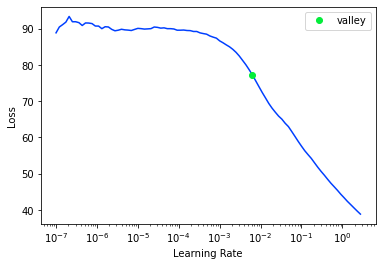

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    7.96       7.99
1    9.14       9.58
2   11.62      10.86
3    8.48       8.60
4    6.47       7.11
XGBoost RMSE:  0.47855633


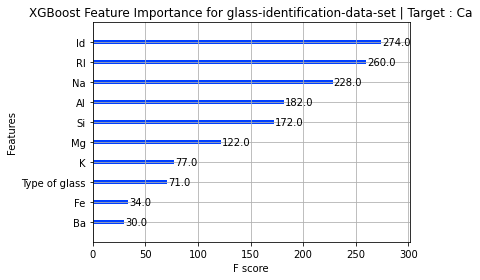

Target Variable: K
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


 10%|▉         | 4/42 [00:00<00:01, 37.20it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5601747645920148, 'Adjusted R-Squared': 0.4182956563958905, 'RMSE': 0.15497435457123632, 'Time taken': 0.05029797554016113}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8429054981400697, 'Adjusted R-Squared': 0.7922298523788018, 'RMSE': 0.09261903614484847, 'Time taken': 0.03351140022277832}
{'Model': 'BayesianRidge', 'R-Squared': 0.877285931901346, 'Adjusted R-Squared': 0.8377007486437156, 'RMSE': 0.08185909542714864, 'Time taken': 0.011441707611083984}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8450803878165056, 'Adjusted R-Squared': 0.7951063193702171, 'RMSE': 0.09197567101865242, 'Time taken': 0.011759519577026367}
{'Model': 'DummyRegressor', 'R-Squared': -0.06795617593135139, 'Adjusted R-Squared': -0.4124581681672712, 'RMSE': 0.24148853, 'Time taken': 0.010060548782348633}
{'Model': 'ElasticNet', 'R-Squared': -0.06795617593135139, 'Adjusted R-Squared': -0.4124581681672712, 'RMSE': 0.24148853, 'Time taken': 0.010974645614624023}


 19%|█▉        | 8/42 [00:00<00:00, 38.08it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8787863758074642, 'Adjusted R-Squared': 0.8396852067130979, 'RMSE': 0.0813571, 'Time taken': 0.06799936294555664}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.5554727146977072, 'Adjusted R-Squared': 0.41207681621309666, 'RMSE': 0.15580054626691328, 'Time taken': 0.01251673698425293}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6967307528435279, 'Adjusted R-Squared': 0.5989019634382144, 'RMSE': 0.12868678500014635, 'Time taken': 0.14112401008605957}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.7080679173483784, 'Adjusted R-Squared': 0.6138962777833392, 'RMSE': 0.12625851504103977, 'Time taken': 0.021315336227416992}


 29%|██▊       | 12/42 [00:00<00:01, 20.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7652197435218606, 'Adjusted R-Squared': 0.6894841769160092, 'RMSE': 0.11322714342220692, 'Time taken': 0.1296544075012207}


 36%|███▌      | 15/42 [00:00<00:01, 19.91it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2610656137047871, 'Adjusted R-Squared': 0.02269968264181521, 'RMSE': 0.20087352595310676, 'Time taken': 0.11984372138977051}
{'Model': 'HuberRegressor', 'R-Squared': 0.8801428588439978, 'Adjusted R-Squared': 0.8414792649227067, 'RMSE': 0.08090059611530334, 'Time taken': 0.026765108108520508}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7269979055575979, 'Adjusted R-Squared': 0.6389327138019844, 'RMSE': 0.12209637, 'Time taken': 0.011772394180297852}
{'Model': 'KernelRidge', 'R-Squared': -3.7434742404643915, 'Adjusted R-Squared': -5.273627221259356, 'RMSE': 0.5089417, 'Time taken': 0.019214153289794922}


 43%|████▎     | 18/42 [00:00<00:01, 21.78it/s]

{'Model': 'Lars', 'R-Squared': -5.224384530203354, 'Adjusted R-Squared': -7.232250507688306, 'RMSE': 0.5829992, 'Time taken': 0.03217649459838867}
{'Model': 'LarsCV', 'R-Squared': 0.5664635864710609, 'Adjusted R-Squared': 0.42661313049398375, 'RMSE': 0.15386242, 'Time taken': 0.05629134178161621}
{'Model': 'Lasso', 'R-Squared': -0.06795617593135139, 'Adjusted R-Squared': -0.4124581681672712, 'RMSE': 0.24148853, 'Time taken': 0.021744251251220703}


 50%|█████     | 21/42 [00:00<00:00, 23.54it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8779918507271562, 'Adjusted R-Squared': 0.8386343832197873, 'RMSE': 0.0816233, 'Time taken': 0.06937956809997559}
{'Model': 'LassoLars', 'R-Squared': -0.06795617593135139, 'Adjusted R-Squared': -0.4124581681672712, 'RMSE': 0.24148853, 'Time taken': 0.01094365119934082}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8768721727405978, 'Adjusted R-Squared': 0.837153518785952, 'RMSE': 0.081996985, 'Time taken': 0.0339202880859375}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8768721727405978, 'Adjusted R-Squared': 0.837153518785952, 'RMSE': 0.081996985, 'Time taken': 0.017673015594482422}
{'Model': 'LinearRegression', 'R-Squared': 0.8768718264170473, 'Adjusted R-Squared': 0.8371530607451271, 'RMSE': 0.081997104, 'Time taken': 0.011598825454711914}
{'Model': 'LinearSVR', 'R-Squared': 0.8881042813192592, 'Adjusted R-Squared': 0.8520088881964396, 'RMSE': 0.07816754987173624, 'Time taken': 0.016801834106445312}


 71%|███████▏  | 30/42 [00:01<00:00, 20.50it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7323858808468775, 'Adjusted R-Squared': 0.6460587456361928, 'RMSE': 0.12088552, 'Time taken': 0.3184239864349365}
{'Model': 'NuSVR', 'R-Squared': 0.7308710106734697, 'Adjusted R-Squared': 0.6440552076649115, 'RMSE': 0.12122718054580746, 'Time taken': 0.03205990791320801}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.14090515781411628, 'Adjusted R-Squared': -0.5089390796896376, 'RMSE': 0.24959997421344116, 'Time taken': 0.022698640823364258}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.14544078562607532, 'Adjusted R-Squared': -0.13022347707519066, 'RMSE': 0.21601844976206017, 'Time taken': 0.034368038177490234}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8445675595881791, 'Adjusted R-Squared': 0.7944280626811401, 'RMSE': 0.09212777813267903, 'Time taken': 0.019652605056762695}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4597817152400415, 'Adjusted R-Squared': 0.2855177524142485, 'RMSE': 0.17175302872263298, 'Time t

 79%|███████▊  | 33/42 [00:02<00:01,  6.90it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.19017331316492747, 'Adjusted R-Squared': -0.5741001883794201, 'RMSE': 0.254932302464544, 'Time taken': 1.105069637298584}
{'Model': 'RANSACRegressor', 'R-Squared': 0.875754448621528, 'Adjusted R-Squared': 0.8356752384994401, 'RMSE': 0.082368314, 'Time taken': 0.13453197479248047}


 83%|████████▎ | 35/42 [00:02<00:00,  7.22it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8146202520411497, 'Adjusted R-Squared': 0.7548203333447464, 'RMSE': 0.10061226084242138, 'Time taken': 0.21050572395324707}
{'Model': 'Ridge', 'R-Squared': 0.8859966304615818, 'Adjusted R-Squared': 0.849221349965318, 'RMSE': 0.07890029, 'Time taken': 0.011957883834838867}
{'Model': 'RidgeCV', 'R-Squared': 0.8788690409859571, 'Adjusted R-Squared': 0.8397945380782013, 'RMSE': 0.08132935765070898, 'Time taken': 0.015419483184814453}
{'Model': 'SGDRegressor', 'R-Squared': 0.6348145615810268, 'Adjusted R-Squared': 0.5170128072523258, 'RMSE': 0.141213588814105, 'Time taken': 0.011956930160522461}
{'Model': 'SVR', 'R-Squared': 0.7181822367093624, 'Adjusted R-Squared': 0.6272732808091568, 'RMSE': 0.12405205020658092, 'Time taken': 0.012961864471435547}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8768718264170473, 'Adjusted R-Squared': 0.8371530607451271, 'RMSE': 0.081997104, 'Time taken': 0.011406660079956055}
{'Model': 'TweedieRegre

100%|██████████| 42/42 [00:03<00:00, 12.37it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8326229424606861, 'Adjusted R-Squared': 0.7786303432544559, 'RMSE': 0.09560217, 'Time taken': 0.398587703704834}
{'Model': 'LGBMRegressor', 'R-Squared': 0.16119227131270097, 'Adjusted R-Squared': -0.1093908669735244, 'RMSE': 0.21401833254614996, 'Time taken': 0.04603981971740723}
Project: glass-identification-data-set
glass-identification-data-set
Target: K
K
Target Standard Deviation: 0.716019868850708
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LinearSVR                                    0.85       0.89  0.08        0.02
Ridge                                        0.85       0.89  0.08        0.01
HuberRegressor                               0.84       0.88  0.08        0.03
RidgeCV                                      0.84       0.88  0.08        0.02
ElasticNetCV                                 0.84       0.88  0.08        0.07

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7.115261077880859.
Better model found at epoch 1 with _rmse value: 4.849379539489746.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

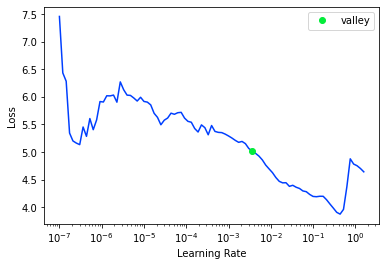

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.58       0.59
1    0.10       0.01
2    0.00       0.00
3    0.57       0.57
4    0.62       0.61
XGBoost RMSE:  0.09555836


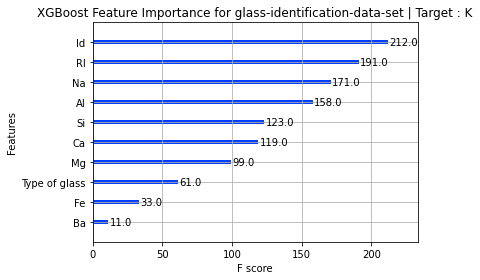

Target Variable: Si
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.43it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4277261511137562, 'Adjusted R-Squared': 0.243121683731097, 'RMSE': 0.550123250583759, 'Time taken': 0.09554123878479004}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5519479800364232, 'Adjusted R-Squared': 0.4074150703707533, 'RMSE': 0.48676828017558194, 'Time taken': 0.03393435478210449}
{'Model': 'BayesianRidge', 'R-Squared': 0.9580650211992306, 'Adjusted R-Squared': 0.9445376086828534, 'RMSE': 0.14891768084810986, 'Time taken': 0.014115095138549805}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.474674642796174, 'Adjusted R-Squared': 0.30521485014977856, 'RMSE': 0.527074775574807, 'Time taken': 0.015309810638427734}
{'Model': 'DummyRegressor', 'R-Squared': -0.002590495025355466, 'Adjusted R-Squared': -0.3260067837432119, 'RMSE': 0.7281483, 'Time taken': 0.011603355407714844}
{'Model': 'ElasticNet', 'R-Squared': -0.002590495025355466, 'Adjusted R-Squared': -0.3260067837432119, 'RMSE': 0.7281483, 'Time taken': 0.012047290802001953}
Elas

 29%|██▊       | 12/42 [00:00<00:01, 21.44it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5329975017162558, 'Adjusted R-Squared': 0.38235153452795123, 'RMSE': 0.496955672480164, 'Time taken': 0.15464544296264648}
{'Model': 'GammaRegressor', 'R-Squared': 0.2593743028485558, 'Adjusted R-Squared': 0.020462787638412583, 'RMSE': 0.6258315285145941, 'Time taken': 0.014566421508789062}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -826.0547115523622, 'Adjusted R-Squared': -1092.8465539886079, 'RMSE': 20.91342534065466, 'Time taken': 0.022236108779907227}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6456998873140546, 'Adjusted R-Squared': 0.5314095283831044, 'RMSE': 0.4328562528183521, 'Time taken': 0.13427352905273438}


 43%|████▎     | 18/42 [00:00<00:01, 22.35it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6387936816352848, 'Adjusted R-Squared': 0.5222755144208606, 'RMSE': 0.43705462414867, 'Time taken': 0.1292285919189453}
{'Model': 'HuberRegressor', 'R-Squared': 0.9573719246175318, 'Adjusted R-Squared': 0.9436209325586712, 'RMSE': 0.1501432847256144, 'Time taken': 0.026018619537353516}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6419562385194755, 'Adjusted R-Squared': 0.5264582509451128, 'RMSE': 0.4351371, 'Time taken': 0.012127399444580078}
{'Model': 'KernelRidge', 'R-Squared': -9986.293158210703, 'Adjusted R-Squared': -13208.000628601252, 'RMSE': 72.674484, 'Time taken': 0.020450353622436523}
{'Model': 'Lars', 'R-Squared': 0.9580046181884571, 'Adjusted R-Squared': 0.9444577208298948, 'RMSE': 0.14902489, 'Time taken': 0.026273250579833984}
{'Model': 'LarsCV', 'R-Squared': 0.9580046181884571, 'Adjusted R-Squared': 0.9444577208298948, 'RMSE': 0.14902489, 'Time taken': 0.053601741790771484}
{'Model': 'Lasso', 'R-Squared': -0.0

 52%|█████▏    | 22/42 [00:00<00:00, 26.47it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed 66.42045593261719 but the user-supplied value was 66.42048645019531.
{'Model': 'LassoLars', 'R-Squared': -0.002590495025355466, 'Adjusted R-Squared': -0.3260067837432119, 'RMSE': 0.7281483, 'Time taken': 0.012692689895629883}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9580046181884571, 'Adjusted R-Squared': 0.9444577208298948, 'RMSE': 0.14902489, 'Time taken': 0.02750396728515625}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9580046181884571, 'Adjusted R-Squared': 0.9444577208298948, 'RMSE': 0.14902489, 'Time taken': 0.016906023025512695}
{'Model': 'LinearRegression', 'R-Squared': 0.9580045388315067, 'Adjusted R-Squared': 0.9444576158739282, 'RMSE': 0.14902504, 'Time taken': 0.011144399642944336}
{'Model': 'LinearSVR', 'R-Squared': 0.9527929865920695, 'Adjusted R-Squared': 0.9375649

 71%|███████▏  | 30/42 [00:01<00:00, 19.07it/s]

{'Model': 'MLPRegressor', 'R-Squared': -5844.534934527778, 'Adjusted R-Squared': -7730.19136502061, 'RMSE': 55.59941, 'Time taken': 0.4077341556549072}
{'Model': 'NuSVR', 'R-Squared': 0.6096206792456613, 'Adjusted R-Squared': 0.48369186609910053, 'RMSE': 0.4543614243318043, 'Time taken': 0.03061652183532715}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.49634275008053297, 'Adjusted R-Squared': 0.3338726694613501, 'RMSE': 0.5160901795647683, 'Time taken': 0.0252382755279541}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8059546461718444, 'Adjusted R-Squared': 0.7433593707434072, 'RMSE': 0.32033889602333676, 'Time taken': 0.03647589683532715}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.936438644590502, 'Adjusted R-Squared': 0.91593498155518, 'RMSE': 0.18333890159810173, 'Time taken': 0.020376205444335938}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9231848639037461, 'Adjusted R-Squared': 0.8984057877436642, 'RMSE': 0.20154937345993337, 'Time taken': 0.014879

 79%|███████▊  | 33/42 [00:02<00:01,  7.70it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.06740966832766349, 'Adjusted R-Squared': -0.4117353677882001, 'RMSE': 0.7513176931416403, 'Time taken': 0.9734151363372803}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9587116203760307, 'Adjusted R-Squared': 0.9453927882392665, 'RMSE': 0.14776513, 'Time taken': 0.04934191703796387}


 83%|████████▎ | 35/42 [00:02<00:00,  7.60it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5752341901751128, 'Adjusted R-Squared': 0.4382129611993427, 'RMSE': 0.47395032610662335, 'Time taken': 0.2611556053161621}
{'Model': 'Ridge', 'R-Squared': 0.9499935727821586, 'Adjusted R-Squared': 0.9338624672280161, 'RMSE': 0.16261888, 'Time taken': 0.011902570724487305}
{'Model': 'RidgeCV', 'R-Squared': 0.9583119455985064, 'Adjusted R-Squared': 0.9448641861141537, 'RMSE': 0.14847859992006737, 'Time taken': 0.013908147811889648}
{'Model': 'SGDRegressor', 'R-Squared': 0.7582181297631676, 'Adjusted R-Squared': 0.6802239780738668, 'RMSE': 0.3575772800705356, 'Time taken': 0.012543678283691406}
{'Model': 'SVR', 'R-Squared': 0.6096338574156648, 'Adjusted R-Squared': 0.4837092952916857, 'RMSE': 0.4543537552490595, 'Time taken': 0.01384425163269043}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9580045388315067, 'Adjusted R-Squared': 0.9444576158739282, 'RMSE': 0.14902504, 'Time taken': 0.011389732360839844}
{'Model': 'TweedieRegress

100%|██████████| 42/42 [00:03<00:00, 12.43it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.669305547874855, 'Adjusted R-Squared': 0.5626299181570662, 'RMSE': 0.41818792, 'Time taken': 0.4447052478790283}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6024861795452889, 'Adjusted R-Squared': 0.474255914882479, 'RMSE': 0.45849453817747765, 'Time taken': 0.04778766632080078}
Project: glass-identification-data-set
glass-identification-data-set
Target: Si
Si
Target Standard Deviation: 0.783277690410614
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RANSACRegressor                              0.95       0.96  0.15        0.05
RidgeCV                                      0.94       0.96  0.15        0.01
BayesianRidge                                0.94       0.96  0.15        0.01
LassoLarsIC                                  0.94       0.96  0.15        0.02
LassoLarsCV                                  0.94       0.96  0.15        0.03


LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 68.35285949707031.
Better model found at epoch 1 with _rmse value: 59.037193298339844.
Better model found at epoch 2 with _rmse value: 46.938018798828125.
Better model found at epoch 3 with _rmse value: 38.14094161987305.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

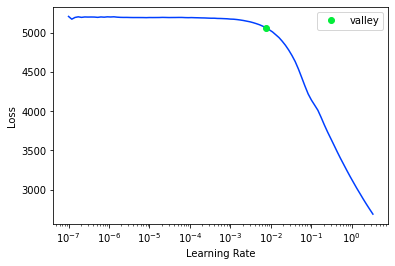

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   72.96      72.91
1   71.50      72.12
2   73.02      72.88
3   72.20      72.35
4   72.64      72.66
XGBoost RMSE:  0.4186574


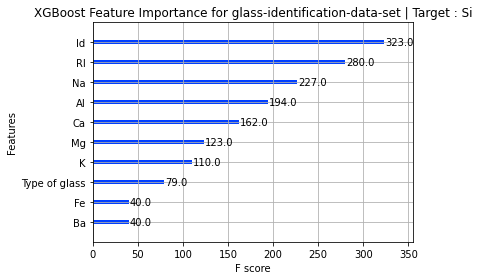

Target Variable: Al
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Mg', 'Si', 'K', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Mg', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.57it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7859389330720237, 'Adjusted R-Squared': 0.716886975998483, 'RMSE': 0.22214896857409547, 'Time taken': 0.0944526195526123}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8385888709979809, 'Adjusted R-Squared': 0.7865207648682973, 'RMSE': 0.19290442765172025, 'Time taken': 0.03382301330566406}
{'Model': 'BayesianRidge', 'R-Squared': 0.9693108377473603, 'Adjusted R-Squared': 0.9594111079884442, 'RMSE': 0.0841139397344901, 'Time taken': 0.012852668762207031}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.625489942965779, 'Adjusted R-Squared': 0.5046802471482883, 'RMSE': 0.29383748668527737, 'Time taken': 0.011862993240356445}
{'Model': 'DummyRegressor', 'R-Squared': -0.10198174135491622, 'Adjusted R-Squared': -0.4574597224371473, 'RMSE': 0.50403726, 'Time taken': 0.010345220565795898}
{'Model': 'ElasticNet', 'R-Squared': -0.10198174135491622, 'Adjusted R-Squared': -0.4574597224371473, 'RMSE': 0.50403726, 'Time taken': 0.01076364517211914}
Elas

 21%|██▏       | 9/42 [00:00<00:01, 27.71it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8474809704651847, 'Adjusted R-Squared': 0.79828128351847, 'RMSE': 0.1875156306867918, 'Time taken': 0.14253902435302734}
{'Model': 'GammaRegressor', 'R-Squared': 0.4717108990445913, 'Adjusted R-Squared': 0.3012950600267176, 'RMSE': 0.34898863469375335, 'Time taken': 0.013861894607543945}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.11069802018247288, 'Adjusted R-Squared': -0.1761735862102778, 'RMSE': 0.4527934000331207, 'Time taken': 0.019345521926879883}


 29%|██▊       | 12/42 [00:00<00:01, 23.50it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7962304112677225, 'Adjusted R-Squared': 0.7304982858702137, 'RMSE': 0.21674303119809454, 'Time taken': 0.13101935386657715}


 36%|███▌      | 15/42 [00:00<00:01, 21.79it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7832930351825241, 'Adjusted R-Squared': 0.7133875626607578, 'RMSE': 0.22351768618606732, 'Time taken': 0.11883211135864258}
{'Model': 'HuberRegressor', 'R-Squared': 0.9728548776239795, 'Adjusted R-Squared': 0.9640983865349406, 'RMSE': 0.07910817402838313, 'Time taken': 0.026607513427734375}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6830811799923404, 'Adjusted R-Squared': 0.5808493025705148, 'RMSE': 0.27030212, 'Time taken': 0.011720657348632812}
{'Model': 'KernelRidge', 'R-Squared': -8.523245062480836, 'Adjusted R-Squared': -11.595259598764976, 'RMSE': 1.4817262, 'Time taken': 0.03149890899658203}


 43%|████▎     | 18/42 [00:00<00:01, 22.41it/s]

{'Model': 'Lars', 'R-Squared': -21.719422483550456, 'Adjusted R-Squared': -29.048268445986086, 'RMSE': 2.2886221, 'Time taken': 0.03401494026184082}
{'Model': 'LarsCV', 'R-Squared': 0.6268247828452871, 'Adjusted R-Squared': 0.5064456805373152, 'RMSE': 0.29331338, 'Time taken': 0.05806922912597656}
{'Model': 'Lasso', 'R-Squared': -0.10198174135491622, 'Adjusted R-Squared': -0.4574597224371473, 'RMSE': 0.50403726, 'Time taken': 0.01784515380859375}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -40.54888916015625 but the user-supplied value was -40.54890823364258.


 57%|█████▋    | 24/42 [00:00<00:00, 31.31it/s]

{'Model': 'LassoLars', 'R-Squared': -0.10198174135491622, 'Adjusted R-Squared': -0.4574597224371473, 'RMSE': 0.50403726, 'Time taken': 0.014749526977539062}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9695695472635805, 'Adjusted R-Squared': 0.9597532721873161, 'RMSE': 0.08375865, 'Time taken': 0.035718679428100586}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9695695472635805, 'Adjusted R-Squared': 0.9597532721873161, 'RMSE': 0.08375865, 'Time taken': 0.01596212387084961}
{'Model': 'LinearRegression', 'R-Squared': 0.9695689098945967, 'Adjusted R-Squared': 0.9597524292154342, 'RMSE': 0.083759524, 'Time taken': 0.011253118515014648}
{'Model': 'LinearSVR', 'R-Squared': 0.9692972930104287, 'Adjusted R-Squared': 0.9593931939815347, 'RMSE': 0.08413249963351886, 'Time taken': 0.020031213760375977}


 67%|██████▋   | 28/42 [00:01<00:00, 16.66it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7682750054474818, 'Adjusted R-Squared': 0.6935250072047341, 'RMSE': 0.23113297, 'Time taken': 0.41033101081848145}
{'Model': 'NuSVR', 'R-Squared': 0.7283671754708385, 'Adjusted R-Squared': 0.640743683687238, 'RMSE': 0.25024567662289554, 'Time taken': 0.031013965606689453}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.47551641802009137, 'Adjusted R-Squared': 0.30632816576850797, 'RMSE': 0.34772939687642745, 'Time taken': 0.024762392044067383}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5389329738323576, 'Adjusted R-Squared': 0.39020167506860204, 'RMSE': 0.3260299447658682, 'Time taken': 0.03994345664978027}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9629054217851054, 'Adjusted R-Squared': 0.9509394288125588, 'RMSE': 0.09247634935125991, 'Time taken': 0.016202926635742188}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4814384246269674, 'Adjusted R-Squared': 0.31416049708727944, 'RMSE': 0.34576069687098965, 'Time take

 76%|███████▌  | 32/42 [00:02<00:01,  8.51it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.050906475560922315, 'Adjusted R-Squared': -0.3899085644515423, 'RMSE': 0.49221800105723373, 'Time taken': 0.907768726348877}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9501049221568998, 'Adjusted R-Squared': 0.9340097357558997, 'RMSE': 0.10725173, 'Time taken': 0.11069607734680176}


 81%|████████  | 34/42 [00:02<00:01,  7.99it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8260874797688994, 'Adjusted R-Squared': 0.769986666791125, 'RMSE': 0.20023541058686384, 'Time taken': 0.20530438423156738}
{'Model': 'Ridge', 'R-Squared': 0.9417258399534129, 'Adjusted R-Squared': 0.9229277238093525, 'RMSE': 0.11590801, 'Time taken': 0.013218402862548828}
{'Model': 'RidgeCV', 'R-Squared': 0.9681666063731813, 'Adjusted R-Squared': 0.9578977697193688, 'RMSE': 0.08566766466768197, 'Time taken': 0.011314868927001953}
{'Model': 'SGDRegressor', 'R-Squared': 0.657420682514322, 'Adjusted R-Squared': 0.5469112252608774, 'RMSE': 0.28103216442957, 'Time taken': 0.01063847541809082}
{'Model': 'SVR', 'R-Squared': 0.7244826268490197, 'Adjusted R-Squared': 0.6356060548648325, 'RMSE': 0.25202867307238236, 'Time taken': 0.012414932250976562}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9695689098945967, 'Adjusted R-Squared': 0.9597524292154342, 'RMSE': 0.083759524, 'Time taken': 0.010871171951293945}
{'Model': 'TweedieRegresso

 98%|█████████▊| 41/42 [00:03<00:00,  7.72it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8221842126183849, 'Adjusted R-Squared': 0.7648242812049607, 'RMSE': 0.20246997, 'Time taken': 0.8686048984527588}


100%|██████████| 42/42 [00:04<00:00, 10.27it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7724462731287107, 'Adjusted R-Squared': 0.6990418451057142, 'RMSE': 0.22904321690097387, 'Time taken': 0.4533562660217285}
Project: glass-identification-data-set
glass-identification-data-set
Target: Al
Al
Target Standard Deviation: 0.49777472019195557
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                               0.96       0.97  0.08        0.03
LassoLarsIC                                  0.96       0.97  0.08        0.02
LassoLarsCV                                  0.96       0.97  0.08        0.04
LinearRegression                             0.96       0.97  0.08        0.01
TransformedTargetRegressor                   0.96       0.97  0.08        0.01
BayesianRidge                                0.96       0.97  0.08        0.01
LinearSVR                                    0.96       0.97  0.08       

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 10.977314949035645.
Better model found at epoch 1 with _rmse value: 3.5802104473114014.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

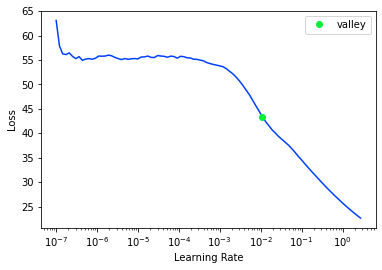

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.11       0.91
1    1.56       1.24
2    1.82       2.01
3    0.67       1.07
4    1.24       1.21
XGBoost RMSE:  0.20246997


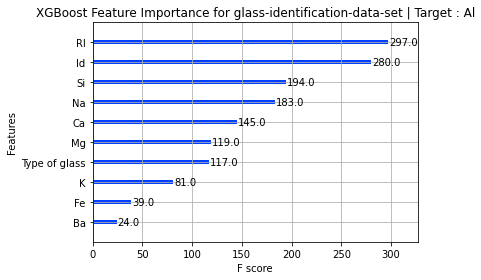

Target Variable: Mg
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Na', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Na', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.33it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8287976192209747, 'Adjusted R-Squared': 0.7735710447761279, 'RMSE': 0.6266753551763252, 'Time taken': 0.09568595886230469}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8763691654524464, 'Adjusted R-Squared': 0.8364882510822678, 'RMSE': 0.5325386296349716, 'Time taken': 0.03457283973693848}
{'Model': 'BayesianRidge', 'R-Squared': 0.9959157020596255, 'Adjusted R-Squared': 0.9945981865949887, 'RMSE': 0.09679355118249852, 'Time taken': 0.013177633285522461}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8449472867256071, 'Adjusted R-Squared': 0.7949302824435449, 'RMSE': 0.596385946696919, 'Time taken': 0.011702299118041992}
{'Model': 'DummyRegressor', 'R-Squared': -0.0070090447564366, 'Adjusted R-Squared': -0.3318506720972225, 'RMSE': 1.5198629, 'Time taken': 0.00988316535949707}
{'Model': 'ElasticNet', 'R-Squared': 0.4019131115291362, 'Adjusted R-Squared': 0.20898185718369633, 'RMSE': 1.1713046, 'Time taken': 0.010916948318481445}


 19%|█▉        | 8/42 [00:00<00:00, 37.18it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -36.72956085205078 but the user-supplied value was -36.72953796386719.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7249346305396693, 'Adjusted R-Squared': 0.6362038661976273, 'RMSE': 0.7943386129116526, 'Time taken': 0.011994123458862305}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9176623036199306, 'Adjusted R-Squared': 0.8911017564005534, 'RMSE': 0.4345973482433504, 'Time taken': 0.13982510566711426}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.752974211874388, 'Adjusted R-Squared': 0.6732884737693519, 'RMSE': 0.7527640371104538, 'Time taken': 0.02464461326599121}


 29%|██▊       | 12/42 [00:00<00:01, 20.61it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8610286442502656, 'Adjusted R-Squared': 0.816199174653577, 'RMSE': 0.5646123366131827, 'Time taken': 0.1325058937072754}


 36%|███▌      | 15/42 [00:00<00:01, 20.13it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8536369939797157, 'Adjusted R-Squared': 0.8064231210699466, 'RMSE': 0.57943320091359, 'Time taken': 0.11941170692443848}
{'Model': 'HuberRegressor', 'R-Squared': 0.9957798418935273, 'Adjusted R-Squared': 0.9944185005688587, 'RMSE': 0.09839025290959286, 'Time taken': 0.024654150009155273}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9406096999716446, 'Adjusted R-Squared': 0.9214515386721751, 'RMSE': 0.3691012, 'Time taken': 0.011242866516113281}
{'Model': 'KernelRidge', 'R-Squared': -2.210369904361366, 'Adjusted R-Squared': -3.245973099316645, 'RMSE': 2.7137215, 'Time taken': 0.017822742462158203}


 43%|████▎     | 18/42 [00:00<00:01, 22.11it/s]

{'Model': 'Lars', 'R-Squared': 0.9948135943342673, 'Adjusted R-Squared': 0.9931405602485471, 'RMSE': 0.10907393, 'Time taken': 0.02991175651550293}
{'Model': 'LarsCV', 'R-Squared': 0.9953295646872472, 'Adjusted R-Squared': 0.9938229726508754, 'RMSE': 0.10350621, 'Time taken': 0.05628681182861328}
{'Model': 'Lasso', 'R-Squared': -0.0025838795559078864, 'Adjusted R-Squared': -0.325998034251362, 'RMSE': 1.5165198, 'Time taken': 0.022426605224609375}


 52%|█████▏    | 22/42 [00:00<00:00, 25.62it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (5,6) we computed -36.72956085205078 but the user-supplied value was -36.72953796386719.
{'Model': 'LassoLars', 'R-Squared': -0.0070090447564366, 'Adjusted R-Squared': -0.3318506720972225, 'RMSE': 1.5198629, 'Time taken': 0.011321067810058594}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9954549911931563, 'Adjusted R-Squared': 0.9939888593199809, 'RMSE': 0.1021069, 'Time taken': 0.027794837951660156}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9956832708341576, 'Adjusted R-Squared': 0.9942907775548536, 'RMSE': 0.099509634, 'Time taken': 0.014933109283447266}
{'Model': 'LinearRegression', 'R-Squared': 0.9959234013867398, 'Adjusted R-Squared': 0.9946083695760107, 'RMSE': 0.09670228, 'Time taken': 0.010344982147216797}
{'Model': 'LinearSVR', 'R-Squared': 0.9958975713072699, 'Adjusted R-Squared': 0.994574

 71%|███████▏  | 30/42 [00:01<00:00, 19.18it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9316907875013369, 'Adjusted R-Squared': 0.9096555576630585, 'RMSE': 0.395847, 'Time taken': 0.3943033218383789}
{'Model': 'NuSVR', 'R-Squared': 0.9335024066576153, 'Adjusted R-Squared': 0.9120515700955557, 'RMSE': 0.3905626239378898, 'Time taken': 0.031028270721435547}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.633342654953172, 'Adjusted R-Squared': 0.5150660920348404, 'RMSE': 0.9171025703785886, 'Time taken': 0.022980928421020508}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7902257735394406, 'Adjusted R-Squared': 0.7225566682295828, 'RMSE': 0.6936873584281519, 'Time taken': 0.03490900993347168}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9954548698897278, 'Adjusted R-Squared': 0.9939886988864142, 'RMSE': 0.10210826009016852, 'Time taken': 0.02089381217956543}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8445987504418121, 'Adjusted R-Squared': 0.7944693151004611, 'RMSE': 0.597055865517452, 'Time taken': 0.014689

 79%|███████▊  | 33/42 [00:02<00:01,  6.45it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.3510575263199138, 'Adjusted R-Squared': -0.7868825348102084, 'RMSE': 1.7604538172211843, 'Time taken': 1.2512538433074951}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9955351559941013, 'Adjusted R-Squared': 0.9940948837341339, 'RMSE': 0.101202406, 'Time taken': 0.06630587577819824}


 83%|████████▎ | 35/42 [00:03<00:01,  6.72it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8688283909072103, 'Adjusted R-Squared': 0.8265149686192137, 'RMSE': 0.5485391623585691, 'Time taken': 0.22816133499145508}
{'Model': 'Ridge', 'R-Squared': 0.9953865056740637, 'Adjusted R-Squared': 0.9938982816979552, 'RMSE': 0.10287331, 'Time taken': 0.013296842575073242}
{'Model': 'RidgeCV', 'R-Squared': 0.9958923453170407, 'Adjusted R-Squared': 0.994567295419312, 'RMSE': 0.09706992170387328, 'Time taken': 0.013086557388305664}
{'Model': 'SGDRegressor', 'R-Squared': 0.9822407504423692, 'Adjusted R-Squared': 0.9765119602624883, 'RMSE': 0.20183664612756433, 'Time taken': 0.012387752532958984}
{'Model': 'SVR', 'R-Squared': 0.932595976716752, 'Adjusted R-Squared': 0.9108527433995752, 'RMSE': 0.39321549741751016, 'Time taken': 0.012641429901123047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9959234013867398, 'Adjusted R-Squared': 0.9946083695760107, 'RMSE': 0.09670228, 'Time taken': 0.011287689208984375}
{'Model': 'TweedieRegres

100%|██████████| 42/42 [00:03<00:00, 11.77it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8530320737562449, 'Adjusted R-Squared': 0.8056230652905174, 'RMSE': 0.5806294, 'Time taken': 0.40381622314453125}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8533995881556353, 'Adjusted R-Squared': 0.8061091327219694, 'RMSE': 0.5799029407864005, 'Time taken': 0.039743900299072266}
Project: glass-identification-data-set
glass-identification-data-set
Target: Mg
Mg
Target Standard Deviation: 1.4188686609268188
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
TransformedTargetRegressor                   0.99       1.00  0.10        0.01
LinearRegression                             0.99       1.00  0.10        0.01
BayesianRidge                                0.99       1.00  0.10        0.01
LinearSVR                                    0.99       1.00  0.10        0.02
RidgeCV                                      0.99       1.00  0.10        0.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 17.2842960357666.
Better model found at epoch 1 with _rmse value: 11.129545211791992.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

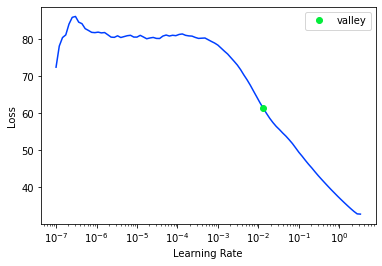

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.00       0.00
1    3.58       3.55
2    3.52       3.56
3    3.75       3.49
4    0.00       0.07
XGBoost RMSE:  0.5806294


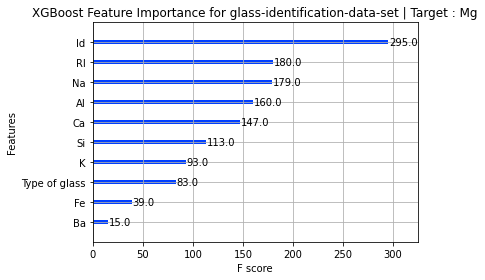

Target Variable: Na
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'RI', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'RI', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.53it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5169751393427806, 'Adjusted R-Squared': 0.3611606681630325, 'RMSE': 0.5204297978891422, 'Time taken': 0.09473681449890137}
{'Model': 'BaggingRegressor', 'R-Squared': 0.1828984249393273, 'Adjusted R-Squared': -0.08068272830605094, 'RMSE': 0.6768858517489003, 'Time taken': 0.03381824493408203}
{'Model': 'BayesianRidge', 'R-Squared': 0.9846810481859473, 'Adjusted R-Squared': 0.9797394508265754, 'RMSE': 0.09268126179579592, 'Time taken': 0.013595342636108398}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.515635232509998, 'Adjusted R-Squared': -1.0045498236422552, 'RMSE': 0.9218807764398079, 'Time taken': 0.011931419372558594}
{'Model': 'DummyRegressor', 'R-Squared': -0.06151910969922514, 'Adjusted R-Squared': -0.40394462895703964, 'RMSE': 0.7715096, 'Time taken': 0.01005697250366211}
{'Model': 'ElasticNet', 'R-Squared': -0.06151910969922514, 'Adjusted R-Squared': -0.40394462895703964, 'RMSE': 0.7715096, 'Time taken': 0.011494159698486328}


 17%|█▋        | 7/42 [00:00<00:01, 30.93it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9845103895813927, 'Adjusted R-Squared': 0.9795137410592614, 'RMSE': 0.09319608, 'Time taken': 0.06830930709838867}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.08458713939286544, 'Adjusted R-Squared': -0.4344539585518543, 'RMSE': 0.779847416899285, 'Time taken': 0.014091014862060547}


 26%|██▌       | 11/42 [00:00<00:01, 25.17it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.40835711344362113, 'Adjusted R-Squared': 0.21750456939317642, 'RMSE': 0.5759797783804423, 'Time taken': 0.14315414428710938}
{'Model': 'GammaRegressor', 'R-Squared': 0.47635225019882677, 'Adjusted R-Squared': 0.3074336212307064, 'RMSE': 0.5418724032062865, 'Time taken': 0.01330876350402832}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -39.8318823612218, 'Adjusted R-Squared': -53.003457316454636, 'RMSE': 4.784946799198944, 'Time taken': 0.019701719284057617}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5223263996061271, 'Adjusted R-Squared': 0.36823814141455524, 'RMSE': 0.5175389407805246, 'Time taken': 0.1339566707611084}


 33%|███▎      | 14/42 [00:00<00:01, 17.22it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.4889579789803229, 'Adjusted R-Squared': 0.3241057141352658, 'RMSE': 0.5353104466002082, 'Time taken': 0.1189732551574707}
{'Model': 'HuberRegressor', 'R-Squared': 0.9833295867750066, 'Adjusted R-Squared': 0.9779520341217829, 'RMSE': 0.09668310632180503, 'Time taken': 0.027753829956054688}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.38421837679294624, 'Adjusted R-Squared': 0.18557914350034832, 'RMSE': 0.58761215, 'Time taken': 0.011705398559570312}
{'Model': 'KernelRidge', 'R-Squared': -320.0571257245474, 'Adjusted R-Squared': -423.62394047440137, 'RMSE': 13.417406, 'Time taken': 0.022945642471313477}
{'Model': 'Lars', 'R-Squared': 0.9846824929800804, 'Adjusted R-Squared': 0.9797413616833321, 'RMSE': 0.09267689, 'Time taken': 0.02776503562927246}


 43%|████▎     | 18/42 [00:00<00:01, 21.08it/s]

{'Model': 'LarsCV', 'R-Squared': 0.957955707070355, 'Adjusted R-Squared': 0.9443930319317599, 'RMSE': 0.15354332, 'Time taken': 0.05881690979003906}
{'Model': 'Lasso', 'R-Squared': -0.06151910969922514, 'Adjusted R-Squared': -0.40394462895703964, 'RMSE': 0.7715096, 'Time taken': 0.02277684211730957}


 50%|█████     | 21/42 [00:00<00:00, 22.92it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9845595435529313, 'Adjusted R-Squared': 0.9795787511506511, 'RMSE': 0.09304809, 'Time taken': 0.06648111343383789}
{'Model': 'LassoLars', 'R-Squared': -0.06151910969922514, 'Adjusted R-Squared': -0.40394462895703964, 'RMSE': 0.7715096, 'Time taken': 0.011561155319213867}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9846824929800804, 'Adjusted R-Squared': 0.9797413616833321, 'RMSE': 0.09267689, 'Time taken': 0.025349140167236328}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9843661141507996, 'Adjusted R-Squared': 0.9793229251671866, 'RMSE': 0.09362911, 'Time taken': 0.013489961624145508}
{'Model': 'LinearRegression', 'R-Squared': 0.984682596931971, 'Adjusted R-Squared': 0.9797414991680907, 'RMSE': 0.09267657, 'Time taken': 0.010693073272705078}
{'Model': 'LinearSVR', 'R-Squared': 0.9835246213882064, 'Adjusted R-Squared': 0.9782099831263374, 'RMSE': 0.09611587293040477, 'Time taken': 0.016399145126342773}


 71%|███████▏  | 30/42 [00:01<00:00, 19.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': -25.1014477553371, 'Adjusted R-Squared': -33.52126961189745, 'RMSE': 3.8256893, 'Time taken': 0.38884830474853516}
{'Model': 'NuSVR', 'R-Squared': 0.5563176613612305, 'Adjusted R-Squared': 0.41319432631646613, 'RMSE': 0.4987851137230959, 'Time taken': 0.03098273277282715}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2805896009486971, 'Adjusted R-Squared': 0.048521730286986586, 'RMSE': 0.6351345942727796, 'Time taken': 0.022875308990478516}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2805896009486971, 'Adjusted R-Squared': 0.048521730286986586, 'RMSE': 0.6351345942727796, 'Time taken': 0.03497934341430664}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9742222198679471, 'Adjusted R-Squared': 0.9659068069221236, 'RMSE': 0.12022649060908841, 'Time taken': 0.02235889434814453}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8823223705403241, 'Adjusted R-Squared': 0.8443618449081707, 'RMSE': 0.25687649593406653, 'Time taken': 

 79%|███████▊  | 33/42 [00:02<00:00, 10.44it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.01660575778383544, 'Adjusted R-Squared': -0.34454309900442737, 'RMSE': 0.7550117236436308, 'Time taken': 0.6219322681427002}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9799393070986293, 'Adjusted R-Squared': 0.9734681158401226, 'RMSE': 0.10605969, 'Time taken': 0.030475616455078125}


 83%|████████▎ | 35/42 [00:02<00:00,  9.70it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4246628983803854, 'Adjusted R-Squared': 0.23907028495470328, 'RMSE': 0.5679872714785674, 'Time taken': 0.24863100051879883}
{'Model': 'Ridge', 'R-Squared': 0.9819108959867568, 'Adjusted R-Squared': 0.9760757011437752, 'RMSE': 0.10071309, 'Time taken': 0.012065887451171875}
{'Model': 'RidgeCV', 'R-Squared': 0.9846473671335089, 'Adjusted R-Squared': 0.9796949049185117, 'RMSE': 0.09278309279997769, 'Time taken': 0.012970924377441406}
{'Model': 'SGDRegressor', 'R-Squared': 0.9139483137792369, 'Adjusted R-Squared': 0.8861897053209262, 'RMSE': 0.21966309844420487, 'Time taken': 0.011628389358520508}
{'Model': 'SVR', 'R-Squared': 0.5587110096699208, 'Adjusted R-Squared': 0.4163597224666695, 'RMSE': 0.4974380004398624, 'Time taken': 0.012570619583129883}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.984682596931971, 'Adjusted R-Squared': 0.9797414991680907, 'RMSE': 0.09267657, 'Time taken': 0.01070404052734375}
{'Model': 'TweedieRegres

100%|██████████| 42/42 [00:02<00:00, 14.20it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.4893209690030962, 'Adjusted R-Squared': 0.3245857977137724, 'RMSE': 0.5351203, 'Time taken': 0.39966869354248047}
{'Model': 'LGBMRegressor', 'R-Squared': 0.483142270377905, 'Adjusted R-Squared': 0.3164139704998099, 'RMSE': 0.5383477726180532, 'Time taken': 0.042653560638427734}
Project: glass-identification-data-set
glass-identification-data-set
Target: Na
Na
Target Standard Deviation: 0.8258962035179138
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
TransformedTargetRegressor                   0.98       0.98  0.09        0.01
LinearRegression                             0.98       0.98  0.09        0.01
LassoLarsCV                                  0.98       0.98  0.09        0.03
Lars                                         0.98       0.98  0.09        0.03
BayesianRidge                                0.98       0.98  0.09        0.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 17.829275131225586.
Better model found at epoch 1 with _rmse value: 8.89411735534668.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

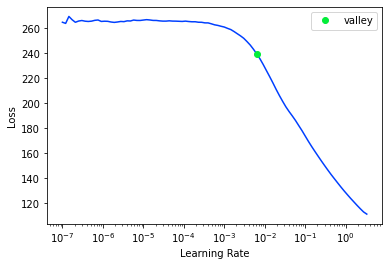

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   13.25      13.09
1   13.33      13.61
2   11.95      14.16
3   14.85      15.04
4   13.21      13.20
XGBoost RMSE:  0.5317569


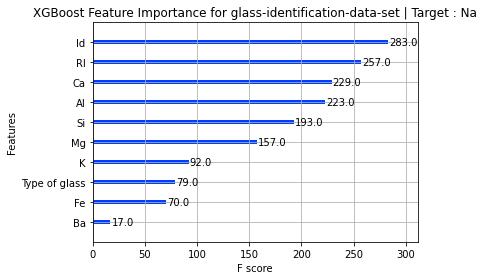

Target Variable: RI
CATS=====================
['Type of glass']
CONTS=====================
['Id', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Id', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Categorical variables that made the cut : ['Type of glass']
Tabular Object size: 214


  5%|▍         | 2/42 [00:00<00:02, 15.59it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5232804730826758, 'Adjusted R-Squared': 0.36949998052870026, 'RMSE': 0.0015579371646047783, 'Time taken': 0.09409213066101074}
{'Model': 'BaggingRegressor', 'R-Squared': 0.553436689447879, 'Adjusted R-Squared': 0.4093840086246142, 'RMSE': 0.0015078564087690324, 'Time taken': 0.03398323059082031}
{'Model': 'BayesianRidge', 'R-Squared': 0.830476056468704, 'Adjusted R-Squared': 0.7757909133940925, 'RMSE': 0.0009290390952530961, 'Time taken': 0.013653278350830078}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.17009757797010538, 'Adjusted R-Squared': -0.09761288074921537, 'RMSE': 0.0020555686373120393, 'Time taken': 0.0130767822265625}
{'Model': 'DummyRegressor', 'R-Squared': -0.22026569756851933, 'Adjusted R-Squared': -0.6138997935583641, 'RMSE': 0.0024925603, 'Time taken': 0.010303258895874023}
{'Model': 'ElasticNet', 'R-Squared': -0.22026569756851933, 'Adjusted R-Squared': -0.6138997935583641, 'RMSE': 0.0024925603, 'Time taken': 0.0110909

 17%|█▋        | 7/42 [00:00<00:01, 29.33it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8388919116488411, 'Adjusted R-Squared': 0.7869215605678221, 'RMSE': 0.00090568495, 'Time taken': 0.07877922058105469}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.22655072137780996, 'Adjusted R-Squared': -0.02294904591967062, 'RMSE': 0.0019844236132189066, 'Time taken': 0.013009071350097656}


 24%|██▍       | 10/42 [00:00<00:01, 22.95it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5923006075954669, 'Adjusted R-Squared': 0.46078467456174654, 'RMSE': 0.0014407495709774757, 'Time taken': 0.14604640007019043}
{'Model': 'GammaRegressor', 'R-Squared': 0.6479261422863369, 'Adjusted R-Squared': 0.5343539301206393, 'RMSE': 0.001338860584426701, 'Time taken': 0.012805700302124023}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -68384.10617591733, 'Adjusted R-Squared': -90443.81784556808, 'RMSE': 0.5900641502661355, 'Time taken': 0.021811485290527344}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7001056489346171, 'Adjusted R-Squared': 0.6033655356877194, 'RMSE': 0.0012356703033050587, 'Time taken': 0.12876510620117188}


 31%|███       | 13/42 [00:00<00:01, 16.60it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.42363779833515935, 'Adjusted R-Squared': 0.23771450747553335, 'RMSE': 0.0017130349064237375, 'Time taken': 0.11526012420654297}
{'Model': 'HuberRegressor', 'R-Squared': 0.8457368602661018, 'Adjusted R-Squared': 0.7959745571261347, 'RMSE': 0.0008862363313301839, 'Time taken': 0.02814006805419922}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3440581083997011, 'Adjusted R-Squared': 0.13246394981895948, 'RMSE': 0.0018274738, 'Time taken': 0.011056661605834961}
{'Model': 'KernelRidge', 'R-Squared': -452813.63915323606, 'Adjusted R-Squared': -598882.8775897638, 'RMSE': 1.5183738, 'Time taken': 0.015716075897216797}
{'Model': 'Lars', 'R-Squared': 0.15009687792561754, 'Adjusted R-Squared': -0.12406541951773153, 'RMSE': 0.002080191, 'Time taken': 0.0262448787689209}


 43%|████▎     | 18/42 [00:00<00:01, 22.15it/s]

{'Model': 'LarsCV', 'R-Squared': 0.843087931441648, 'Adjusted R-Squared': 0.7924711351325021, 'RMSE': 0.0008938129, 'Time taken': 0.05534219741821289}
{'Model': 'Lasso', 'R-Squared': -0.22026569756851933, 'Adjusted R-Squared': -0.6138997935583641, 'RMSE': 0.0024925603, 'Time taken': 0.02522754669189453}


 50%|█████     | 21/42 [00:00<00:00, 23.16it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8388848712373446, 'Adjusted R-Squared': 0.7869122490558428, 'RMSE': 0.00090570474, 'Time taken': 0.07598304748535156}
{'Model': 'LassoLars', 'R-Squared': -0.22026569756851933, 'Adjusted R-Squared': -0.6138997935583641, 'RMSE': 0.0024925603, 'Time taken': 0.011148452758789062}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8318769111858609, 'Adjusted R-Squared': 0.777643656729687, 'RMSE': 0.0009251926, 'Time taken': 0.032277822494506836}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8318769111858609, 'Adjusted R-Squared': 0.777643656729687, 'RMSE': 0.0009251926, 'Time taken': 0.015516281127929688}
{'Model': 'LinearRegression', 'R-Squared': 0.8293894473648611, 'Adjusted R-Squared': 0.7743537852244937, 'RMSE': 0.0009320118, 'Time taken': 0.010748147964477539}
{'Model': 'LinearSVR', 'R-Squared': 0.7498863629627559, 'Adjusted R-Squared': 0.669204544563645, 'RMSE': 0.0011284625546076697, 'Time taken': 0.022259950637817383}


 69%|██████▉   | 29/42 [00:01<00:00, 21.10it/s]

{'Model': 'MLPRegressor', 'R-Squared': -10137.639875464625, 'Adjusted R-Squared': -13408.168867549988, 'RMSE': 0.22719999, 'Time taken': 0.24567675590515137}
{'Model': 'NuSVR', 'R-Squared': 0.09155955703597185, 'Adjusted R-Squared': -0.20148574714597256, 'RMSE': 0.002150634938909148, 'Time taken': 0.04236888885498047}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5827706365517935, 'Adjusted R-Squared': 0.44818051931043656, 'RMSE': 0.001457491059680464, 'Time taken': 0.022182941436767578}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8237194227442478, 'Adjusted R-Squared': 0.7668547204036826, 'RMSE': 0.0009473723359435185, 'Time taken': 0.033072710037231445}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -584.5439595979498, 'Adjusted R-Squared': -773.4291078553529, 'RMSE': 0.05460070111576873, 'Time taken': 0.01672959327697754}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7390449341815627, 'Adjusted R-Squared': 0.6548658806917442, 'RMSE': 0.001152660293181704, 'T

 79%|███████▊  | 33/42 [00:58<00:41,  4.57s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -1.7953521372932387e+131, 'Adjusted R-Squared': -2.374497988032993e+131, 'RMSE': 9.560779195202161e+62, 'Time taken': 56.93682861328125}
{'Model': 'RANSACRegressor', 'R-Squared': 0.7949082171443097, 'Adjusted R-Squared': 0.7287495775134418, 'RMSE': 0.0010218628, 'Time taken': 0.10963034629821777}


 83%|████████▎ | 35/42 [00:58<00:24,  3.48s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5728571710072001, 'Adjusted R-Squared': 0.4350691616546841, 'RMSE': 0.0014747045719220194, 'Time taken': 0.19774818420410156}
{'Model': 'Ridge', 'R-Squared': 0.830439011091439, 'Adjusted R-Squared': 0.775741917895129, 'RMSE': 0.0009291406, 'Time taken': 0.012244939804077148}
{'Model': 'RidgeCV', 'R-Squared': 0.833172643336836, 'Adjusted R-Squared': 0.7793573669938799, 'RMSE': 0.0009216204463470675, 'Time taken': 0.014267206192016602}
{'Model': 'SGDRegressor', 'R-Squared': -39.01546348850701, 'Adjusted R-Squared': -51.923677517057655, 'RMSE': 0.014273562880405615, 'Time taken': 0.010925531387329102}
{'Model': 'SVR', 'R-Squared': -5.997055512951581, 'Adjusted R-Squared': -8.254170194548864, 'RMSE': 0.005968650190303321, 'Time taken': 0.010441780090332031}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8293894473648611, 'Adjusted R-Squared': 0.7743537852244937, 'RMSE': 0.0009320118, 'Time taken': 0.010696887969970703}
{'Model': 'Tw

100%|██████████| 42/42 [00:59<00:00,  1.41s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.6639501294409104, 'Adjusted R-Squared': 0.5555469453895912, 'RMSE': 0.0013080379, 'Time taken': 0.37065815925598145}
{'Model': 'LGBMRegressor', 'R-Squared': 0.41153707907054715, 'Adjusted R-Squared': 0.22171033038362686, 'RMSE': 0.0017309240746832678, 'Time taken': 0.05137181282043457}
Project: glass-identification-data-set
glass-identification-data-set
Target: RI
RI
Target Standard Deviation: 0.003155567916110158
                                                                                                                                                    Adjusted R-Squared  \
Model                                                                                                                                                                    
HuberRegressor                                                                                                                                                    0.80   
LarsCV                         

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 11.531155586242676.
Better model found at epoch 1 with _rmse value: 11.422700881958008.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

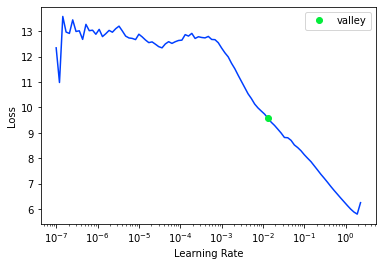

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.52       1.52
1    1.52       1.52
2    1.51       1.51
3    1.52       1.52
4    1.52       1.52
XGBoost RMSE:  0.0013080379


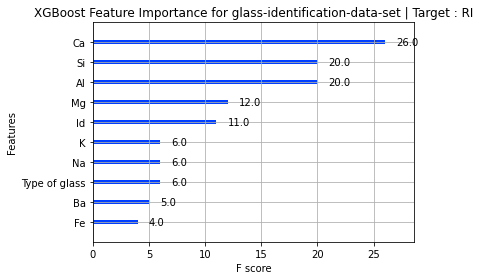

<Figure size 432x288 with 0 Axes>

In [19]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

         feature  importance
0  Type of glass      117.00
1             Id      280.00
2             RI      297.00
3             Na      183.00
4             Mg      119.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

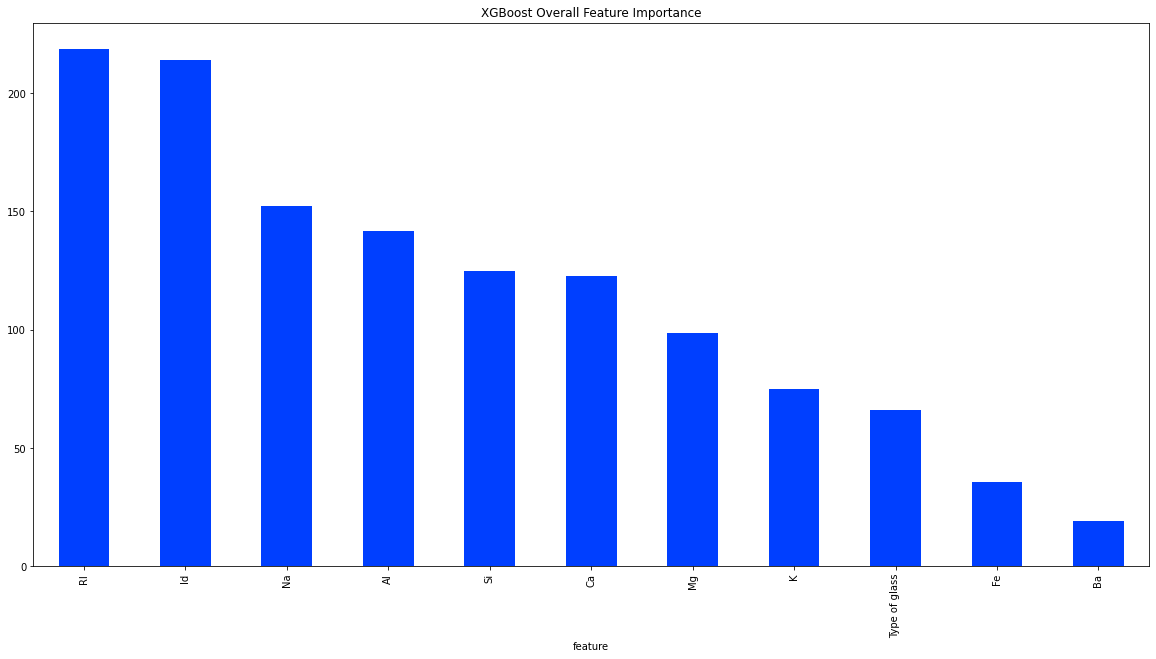

In [20]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [21]:
df.isna().sum()

Id               0
RI               0
Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type of glass    0
dtype: int64

# **To Be Continued...**